In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control.matlab as ctl

from scipy.optimize import minimize, check_grad, approx_fprime
from scipy.optimize import LinearConstraint, BFGS

In [142]:
# === 設計仕様の決定 ===
Cr = 1
# サンプリングタイムと演算子
Ts = 0.001
s = ctl.tf([1,0], [1])      # ラプラス演算子 s
z = ctl.tf([1, 0], [1], Ts)    # 時間進み演算子 z

# 参照モデル Td
tau = 0.020
Td = ctl.c2d(1/(tau*s + 1), Ts)    # ゼロ次ホールドで離散化した一次遅れ系

# 制御器構造 C(rho)
#Crho = lambda rho: rho[0] + rho[1]*Ts/(1-z**-1) + rho[2]*(1-z**-1)/Ts # PID制御器
Crho = lambda rho: rho[0] + rho[1]/(1-z**-1) # PI制御器

# 初期制御器のパラメータ
#rho0 = np.array([10, 0.0, 0.0])              # 適当な比例制御器（安定化する）
rho0 = np.array([10.0, 1.0])              # 適当な比例制御器（安定化する）

# 初期制御器 C0
C0 = Crho(rho0)


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


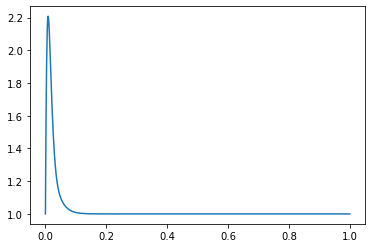

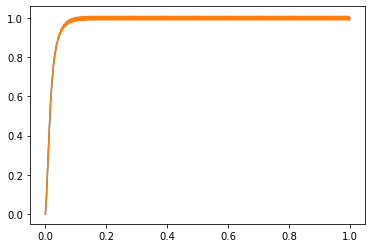

In [148]:
# === 入出力データの取得 ===
# データ取得に用いる入力信号 r (ステップ信号)
N  = 1000           # データ数
r0 = np.ones(N)     # 信号のベクトル

# 制御対象モデル P
Tp = 0.050
Kp = 1
P = ctl.c2d(Kp/(Tp*s + 1), Ts)

# 初期の閉ループシステム
Tu0 = (Cr + Td*C0)/(1 + P*C0)
T0 = P*Tu0

# 制御対象の出力信号 y0
y0, t0, _ = ctl.lsim(T0, r0)

# 制御入力信号 u0
u0, _, _ = ctl.lsim(Tu0, r0)

# ノイズ
A = 0.01   # 振幅
noise = 2*A*(np.random.rand(round(len(t0)))-0.5) # ホワイトノイズの生成f

Anoise1 = 0.01
fnoise1 = 0.5e3
Anoise2 = 0.01
fnoise2 = 0.2e3
noise = Anoise1 * np.sin(2 * np.pi *fnoise1 * t0) + Anoise2 * np.sin(2 * np.pi * fnoise2 * t0)

u0_noise = u0 + noise
y0_noise = y0 + noise

plt.figure()
plt.plot(t0, u0)
plt.figure()
plt.plot(t0, y0)
plt.plot(t0, y0_noise)


In [149]:
def e_tilde(C, Td, y0, u0):
    _u, _, _ = ctl.lsim(1/(Cr + Td*C), u0.flatten())
    _y, _, _ = ctl.lsim(C/(Cr + Td*C), y0.flatten())
    r_tilde = _u + _y
    y_tilde, _, _ = ctl.lsim(Td, r_tilde.flatten())
    return y0 - y_tilde
    
def J_e_tilde(C, Td, y0, u0):
    # FRIT の評価関数
    _e_tilde = e_tilde(C, Td, y0, u0)
    return np.linalg.norm(_e_tilde, 2)**2

def J_e_tilde_jac(C, Td, y0, u0):
    e_tilde_d_kp_y0, _, _ = ctl.lsim(Td**2/(Td*C + Cr)**2*C - Td/(Td*C + Cr), y0.flatten())
    e_tilde_d_kp_u0, _, _ = ctl.lsim(Td**2/(Td*C + Cr)**2, u0.flatten())
    e_tilde_d_ki_y0, _, _ = ctl.lsim(Td**2/(Td*C + Cr)**2/(1-z**(-1))*C - Td/(Td*C + Cr)/(1-z**(-1)), y0.flatten())
    e_tilde_d_ki_u0, _, _ = ctl.lsim(Td**2/(Td*C + Cr)**2/(1-z**(-1)), u0.flatten())
    e_tilde_d_kp = e_tilde_d_kp_y0 + e_tilde_d_kp_u0
    e_tilde_d_ki = e_tilde_d_ki_y0 + e_tilde_d_ki_u0
    e_tilde_d = np.array([e_tilde_d_kp, e_tilde_d_ki])
    _e_tilde = e_tilde(C, Td, y0, u0)
    jac_frit = 2 * np.dot(e_tilde_d, _e_tilde)
    return jac_frit

def J_e_tilde_hessian(C, Td, y0, u0):
    jac = np.array([J_e_tilde_jac(C, Td, y0, u0)])
    return np.dot(jac.T, jac)

# 最適化問題の評価関数 f(x)とそのヤコビアン
f = lambda x: J_e_tilde(Crho(x), Td, y0, u0)
f_jac = lambda x: J_e_tilde_jac(Crho(x), Td, y0, u0)
f_hessian = lambda x: J_e_tilde_hessian(Crho(x), Td, y0, u0)

#確認
eps = np.sqrt(np.finfo(float).eps)

print(f_jac((1, 2)))
print(approx_fprime((1, 2), f, [eps, eps]))

print(f_jac((10, 2)))
print(approx_fprime((10, 2), f, [eps, eps]))

print(check_grad(f, f_jac, [10, 2]))

print(f_hessian([10, 2]))

# f = lambda x: J_e_tilde(Crho(x), Td, y0_noise, u0_noise)
# f_jac = lambda x: J_e_tilde_jac(Crho(x), Td, y0_noise, u0_noise)
# f_hessian = lambda x: J_e_tilde_hessian(Crho(x), Td, y0_noise, u0_noise)



C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


[-0.07391054 -0.12287655]
[-0.07391819 -0.12291496]
[-0.00306022 -0.01774228]
[-0.00310834 -0.01777673]
5.918789017556136e-05
[[9.36492199e-06 5.42952198e-05]
 [5.42952198e-05 3.14788622e-04]]


In [152]:
# === FRITによる設計 ===
Kpmax = np.inf
Kimax = 3

def callbackFunc_trust(xk, state):
    callbackFunc_trust.epoch += 1
    print("{}: Jfrit = {:4.4f}, rho = {}".format(
        callbackFunc_trust.epoch, 
        state["fun"], 
        np.round(xk, 4)))
callbackFunc_trust.epoch = 0
    
def callbackFunc(xk):
    callbackFunc.epoch += 1
    print("{}: Jfrit = {:4.4f}, rho = {}".format(
        callbackFunc.epoch,
        f(xk),
        np.round(xk, 4)))    
callbackFunc.epoch = 0

bounds=((0, Kpmax), (0, Kimax))

# 最適なパラメータ rho

print("trust-constr")
optResult = minimize(f, rho0,
                     method="trust-constr", 
#                      jac=f_jac,
                     hess=BFGS(),
                     bounds=bounds,
                     options={"maxiter":np.inf, "disp":True},
                     callback=callbackFunc_trust
                      )
# print("TNC")
# optResult = minimize(f, rho0,
#                      method="TNC", 
#                      jac=f_jac,
#                      hess=f_hessian,
#                      bounds=bounds,
#                      options={"disp":True},
#                      callback=callbackFunc
#                       )
print("Powell")
callbackFunc.epoch = 0
optResult = minimize(f, rho0,
                     method="Powell",
                     bounds=bounds,
                     options={"maxiter":np.inf, "disp":True},
                     callback=callbackFunc
                     )
print("L-BFGS-B")
callbackFunc.epoch = 0
optResult = minimize(f, rho0,
                     method="L-BFGS-B",
                     jac=f_jac,
                     bounds=bounds,
                     options={"maxiter":np.inf, "disp":True},
                     callback=callbackFunc
                     )

rho = optResult["x"]
# 設計した制御器 C
C = Crho(rho)  # 制御器を求める

# 評価値
print("初期の評価値\t： {:5.3f}".format(f(rho0)))
print("設計後の評価値\t： {:5.3f}".format(f(rho)))


trust-constr
1: Jfrit = 0.0620, rho = [10.  1.]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


2: Jfrit = 0.0583, rho = [10.0148  1.0784]
3: Jfrit = 0.0583, rho = [10.0148  1.0784]
4: Jfrit = 0.0376, rho = [10.2337  1.6967]
5: Jfrit = 0.0376, rho = [10.2337  1.6967]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


6: Jfrit = 0.0278, rho = [10.4188  2.2108]
7: Jfrit = 0.0229, rho = [10.5902  2.5833]
8: Jfrit = 0.0229, rho = [10.5902  2.5833]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


9: Jfrit = 0.0198, rho = [10.7569  2.8782]
10: Jfrit = 0.0198, rho = [10.7945  2.8789]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


11: Jfrit = 0.0132, rho = [17.4357  2.7983]
12: Jfrit = 0.0132, rho = [17.4357  2.7983]
13: Jfrit = 0.0099, rho = [23.1776  2.8037]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


14: Jfrit = 0.0069, rho = [32.398   2.8074]
15: Jfrit = 0.0069, rho = [32.398   2.8074]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


16: Jfrit = 0.0069, rho = [32.398   2.8074]
17: Jfrit = 0.0069, rho = [32.398   2.8074]
18: Jfrit = 0.0069, rho = [32.398   2.8074]
19: Jfrit = 0.0069, rho = [32.398   2.8074]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


20: Jfrit = 0.0069, rho = [32.398   2.8074]
21: Jfrit = 0.0068, rho = [32.5817  2.8408]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


22: Jfrit = 0.0064, rho = [34.322   2.9031]
23: Jfrit = 0.0064, rho = [34.322   2.9031]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningles

24: Jfrit = 0.0064, rho = [34.322   2.9031]
25: Jfrit = 0.0063, rho = [34.5149  2.9737]
26: Jfrit = 0.0063, rho = [34.7151  2.9741]
27: Jfrit = 0.0062, rho = [35.9257  2.9764]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


28: Jfrit = 0.0062, rho = [35.5864  2.9765]
29: Jfrit = 0.0062, rho = [35.5864  2.9765]
30: Jfrit = 0.0062, rho = [35.6803  2.9951]
31: Jfrit = 0.0062, rho = [35.6803  2.9951]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


32: Jfrit = 0.0062, rho = [35.703   2.9991]
33: Jfrit = 0.0062, rho = [35.6708  2.9991]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


34: Jfrit = 0.0062, rho = [35.6652  2.9991]
35: Jfrit = 0.0062, rho = [35.6652  2.9991]
36: Jfrit = 0.0062, rho = [35.6378  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


37: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


38: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


39: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


40: Jfrit = 0.0062, rho = [35.6518  2.9998]
41: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


42: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


43: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


44: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


45: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


46: Jfrit = 0.0062, rho = [35.6518  2.9998]
47: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


48: Jfrit = 0.0062, rho = [35.6518  2.9998]
49: Jfrit = 0.0062, rho = [35.6518  2.9998]
50: Jfrit = 0.0062, rho = [35.6518  2.9998]
51: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


52: Jfrit = 0.0062, rho = [35.6518  2.9998]
53: Jfrit = 0.0062, rho = [35.6518  2.9998]
54: Jfrit = 0.0062, rho = [35.6518  2.9998]
55: Jfrit = 0.0062, rho = [35.6518  2.9998]
56: Jfrit = 0.0062, rho = [35.6518  2.9998]
57: Jfrit = 0.0062, rho = [35.6518  2.9998]
58: Jfrit = 0.0062, rho = [35.6518  2.9998]
59: Jfrit = 0.0062, rho = [35.6518  2.9998]
60: Jfrit = 0.0062, rho = [35.6518  2.9998]
61: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


62: Jfrit = 0.0062, rho = [35.6518  2.9998]
63: Jfrit = 0.0062, rho = [35.6518  2.9998]
64: Jfrit = 0.0062, rho = [35.6518  2.9998]
65: Jfrit = 0.0062, rho = [35.6518  2.9998]
66: Jfrit = 0.0062, rho = [35.6518  2.9998]
67: Jfrit = 0.0062, rho = [35.6518  2.9998]
68: Jfrit = 0.0062, rho = [35.6518  2.9998]
69: Jfrit = 0.0062, rho = [35.6518  2.9998]
70: Jfrit = 0.0062, rho = [35.6518  2.9998]
71: Jfrit = 0.0062, rho = [35.6518  2.9998]


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


72: Jfrit = 0.0062, rho = [35.6518  2.9998]
73: Jfrit = 0.0062, rho = [35.6518  2.9998]
74: Jfrit = 0.0062, rho = [35.6518  2.9998]
75: Jfrit = 0.0062, rho = [35.6518  2.9998]
76: Jfrit = 0.0062, rho = [35.6518  2.9998]
77: Jfrit = 0.0062, rho = [35.6518  2.9998]
78: Jfrit = 0.0062, rho = [35.6518  2.9998]
79: Jfrit = 0.0062, rho = [35.6518  2.9998]
80: Jfrit = 0.0062, rho = [35.6518  2.9998]
81: Jfrit = 0.0062, rho = [35.6518  2.9998]
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 177, CG iterations: 86, optimality: 1.12e-06, constraint violation: 0.00e+00, execution time:  7.0 s.
Powell


C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(
C:\Users\Kobayashi\anaconda3\lib\site-packages\control\timeresp.py:940: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


1: Jfrit = 0.0070, rho = [37.6103  3.    ]


<ipython-input-149-93549efa2bb9>:4: RuntimeWarning: invalid value encountered in add
  r_tilde = _u + _y
C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: overflow encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\Kobayashi\anaconda3\lib\site-packages\scipy\signal\ltisys.py:3485: RuntimeWarning: invalid value encountered in add
  xout[i+1, :] = (np.dot(system.A, xout[i, :]) +


2: Jfrit = 0.0062, rho = [35.6577  3.    ]
3: Jfrit =  nan, rho = [4.66169968e+07 1.85410000e+00]
L-BFGS-B
1: Jfrit = 0.0597, rho = [10.0073  1.0479]
2: Jfrit = 0.0202, rho = [10.0188  2.9693]
3: Jfrit = 0.0199, rho = [10.0917  3.    ]
4: Jfrit = 0.0185, rho = [10.9725  3.    ]
5: Jfrit = 0.0124, rho = [17.262  3.   ]
6: Jfrit = 0.0093, rho = [23.1205  3.    ]
7: Jfrit = 0.0066, rho = [32.0682  3.    ]
8: Jfrit = 0.0062, rho = [34.7553  3.    ]
9: Jfrit = 0.0062, rho = [35.5582  3.    ]
10: Jfrit = 0.0062, rho = [35.7013  3.    ]
初期の評価値	： 0.062
設計後の評価値	： 0.006


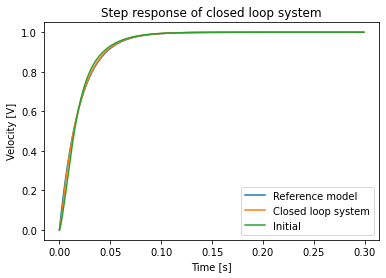

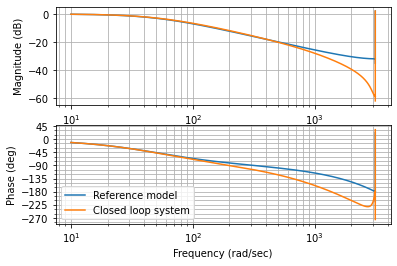

In [153]:
# === 性能の確認 ===
# 制御器を実装したシステム全体 G
G = ctl.minreal((P*Cr + P*Td*C)/(1 + P*C), verbose=False)

# ステップ応答
plt.figure()
plt.title("Step response of closed loop system")
timeRange = t0[t0 < 15*tau]
ym, _ = ctl.step(Td, timeRange)
yg, _ = ctl.step(G, timeRange)
plt.plot(timeRange, ym)
plt.plot(timeRange, yg)
plt.plot(timeRange, y0[:len(timeRange)])
plt.xlabel("Time [s]")
plt.ylabel("Velocity [V]")
plt.legend(['Reference model', 'Closed loop system', 'Initial'], loc='lower right')

# ボード線図表示
plt.figure()
plt.title("Bode plot of closed loop system")
ctl.bode(Td, G)
plt.legend(['Reference model', 'Closed loop system'], loc='lower left')

plt.show()